# Importamos las librerías necesaria


In [7]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, lfilter, find_peaks, welch, iirnotch
from scipy.integrate import cumtrapz, trapz
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pywt

## Definimos las funciones que servirán para tratar las señales

In [8]:
#Función que permite extraer las señales EEG del archivo propio del bitalino
def extract_file_Bitalino(file):
    signal = np.genfromtxt(file + ".txt", delimiter="\t")
    signal = signal[:,-2]
    return signal

#Permite obtener de manera "analógica" la data del EEG
def tomV_byBitalino(ADC, n = 10, VCC = 3.3):
    volts = (((ADC/(2**n))-(1/2)) * VCC)/1009
    return volts*1000
#FILTROS BUTHERWORTH. Perfecto para las señales en frecuencia.
#FILTRO PASABANDA->Permite obtener las señales entre 2 frecuencias de corte
def butter_bandpass(lowcuttoff_wide, highcuttoff_wide, fs, order=5):
    nyq = 0.5 * fs #frec de nyquist"como mínimo la mitad de la frecucncia de sampleo
    low = lowcuttoff_wide / nyq  
    high = highcuttoff_wide / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def extract_features(signal):
    mean = np.mean(signal) #media
    std = np.std(signal) #desviación estandar
    amplitude = np.max(signal) - np.min(signal) #amplitud de la señal
    fft_signal = np.fft.fft(signal) #la representaciónde la señal en frecuencia
    dominant_frequency = np.argmax(np.abs(fft_signal)) #buscamos la frecuencia con mayor poder espectral
    peaks, _ = find_peaks(signal) #la función find_peaks devuelve los índices de la señal
    duration = (peaks[-1]-peaks[0])/len(signal) #la duración de un periodo
    power = np.sum(np.square(signal))/len(signal) #la cantidad de energía de la señal
    kurtosis = np.sum((signal - mean)**4)/(len(signal)*std**4) #distribución de los datos según kurtosis
    coeffs = pywt.wavedec(signal, 'db4', level = 5) #Se está aplicando una descomposición wavelet a la señal utilizando la transformada wavelet discreta. La señal se descompone en diferentes niveles utilizando la onda madre 'db4' y se obtienen los coeficientes de aproximación y detalle en cada nivel.
    cA5,cD5,cD4,cD3,cD2,cD1 = coeffs # Se asignan los coeficientes de aproximación y detalle a variables individuales para cada nivel de descomposición.
    wavelet = np.concatenate((cD1, cD2, cD3, cD4, cD5)) #Se concatenan los coeficientes de detalle de cada nivel en un solo vector llamado "wavelet".
    rms = np.sqrt(np.sum(signal * signal)/len(signal)) #Se calcula la raíz cuadrada de la media del cuadrado de la señal, lo cual corresponde al valor eficaz o root mean square (RMS) de la señal.
    area = cumtrapz(signal) #Se realiza la integración acumulada (cumtrapz) de la señal.
    f,P = welch(signal,fs = 1000, window='hann', noverlap=0,nfft = int(256.)) #Se calcula la densidad espectral de potencia utilizando el método de Welch, que divide la señal en segmentos solapados y aplica una ventana en cada segmento antes de calcular la transformada de Fourier.
    area_freq = cumtrapz(P,f,initial=0) # Se realiza la integración acumulada de la densidad espectral de potencia
    total_power = area_freq[-1] #Se obtiene la potencia total sumando el último valor de la integración acumulada.
    median_freq = f[np.where(area_freq > total_power/2)[0][0]] # Se calcula la frecuencia mediana que divide la potencia total en dos mitades iguales. Se calcula la frecuencia mediana que divide la potencia total en dos mitades iguales.
    f_max = f[np.argmax(P)] #Se obtiene la frecuencia con mayor amplitud (pico máximo) de la densidad espectral de potencia.
    features =  {'media': mean,
                 'desviacion_estandar': std,
                 'amplitud': amplitude,
                 'frecuencia_dominante': dominant_frequency,
                 'potencia': power,
                 'kurtosis': kurtosis,
                 'wavelet': wavelet,
                 'rms': rms,
                 'area': area,
                 'min_value': np.min(signal),
                 'max_value': np.max(signal),
                 'area_freq': area_freq,
                 'total_power': total_power,
                 'median_freq': median_freq,
                 'f_max': f_max                 
                 }
    #diccionario """"""features"""""" que contiene todas las características extraídas de la señal.
    return features

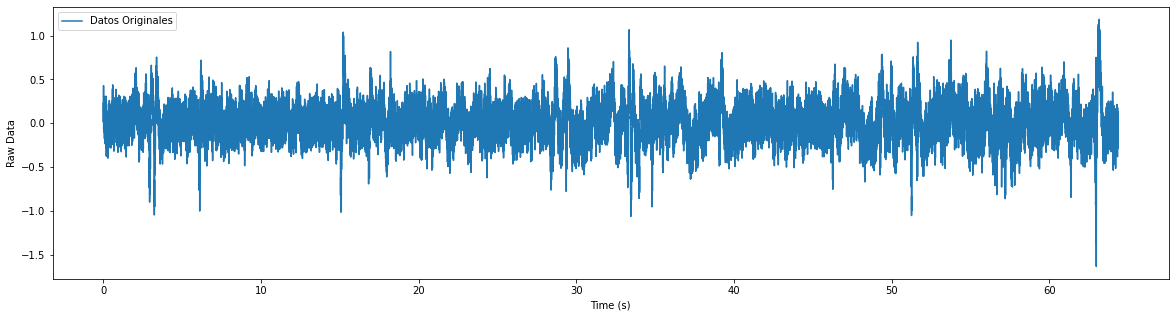

In [11]:
fs = 1000; ts = 1/fs # Bitalino's sampling rate
# Los archivos tomados por Bitalino fueron: Registro1.txt y Registro2.txt
signal = extract_file_Bitalino('Registro1')
signal = tomV_byBitalino(signal)
time = np.arange(len(signal))*ts
plt.figure(figsize=(20,5))
plt.plot(time, signal, label = 'Datos Originales')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

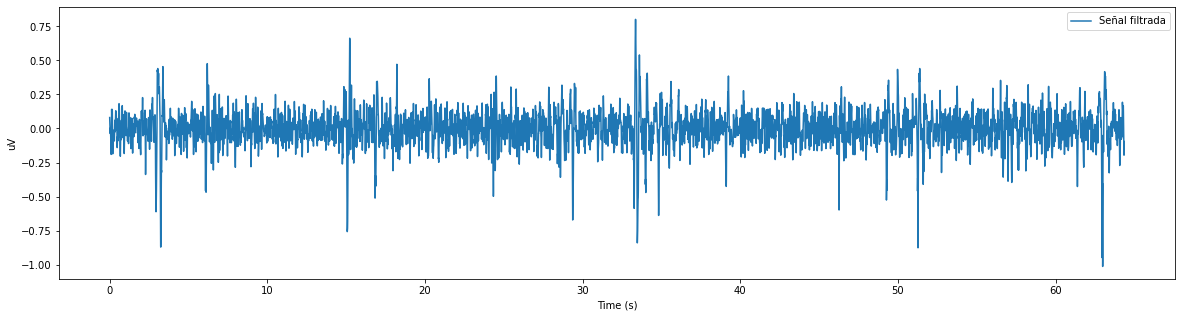

In [16]:
#COLOCAMOS LOS LÍMITES DE LAS SEÑAL ENTRE 3 Y 30 PORQUE SON LOS VALORES 
#EN FRECUENCIA DE LAS ONDAS DELTA,THETA,ALPHA,BETA *TODAS JUNTAS*
low_cutoff_wide = 3
high_cutoff_wide = 30
#SETEAMOS LA VARIABLE DE SEÑAL FILTRADA

filtered_eeg = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, filtered_eeg, label = 'Señal filtrada')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

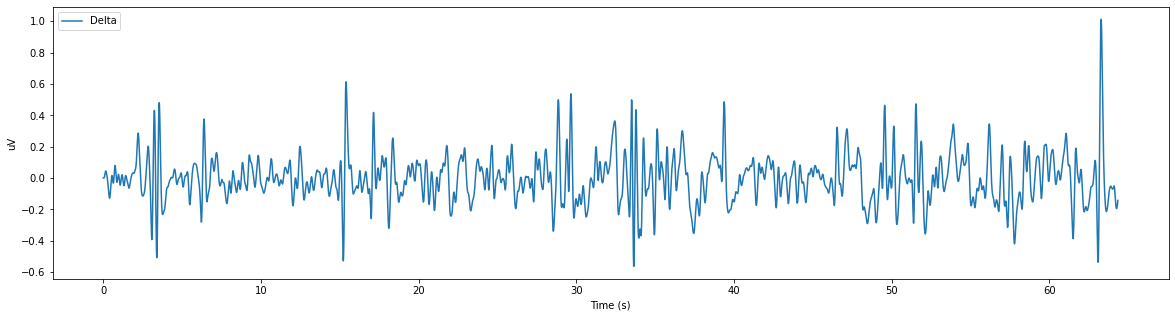

In [17]:
# Extracción de ondas delta:

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


low_cutoff_wide = 4

delta = butter_lowpass_filter(signal, low_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, delta, label = 'Delta')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

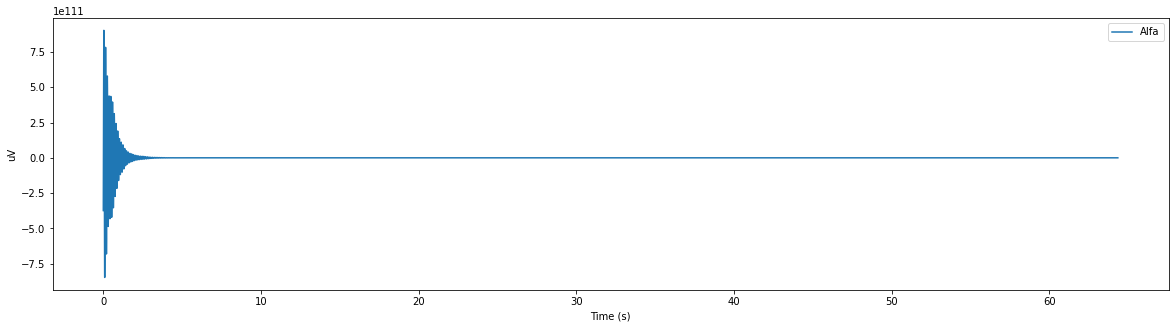

In [18]:
# Extracción de ondas alfa:

low_cutoff_wide = 8
high_cutoff_wide = 12

alfa = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, alfa, label = 'Alfa')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

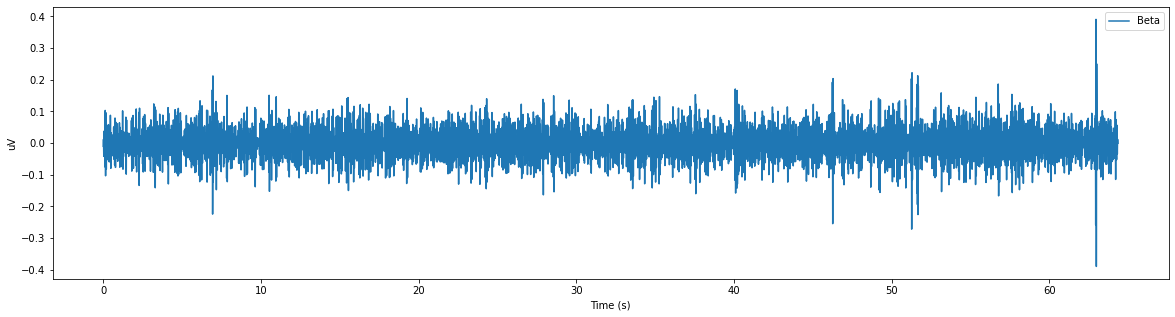

In [19]:
# Extracción de ondas Beta:

low_cutoff_wide = 13
high_cutoff_wide = 30

beta = butter_bandpass_filter(signal, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time, beta, label = 'Beta')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [20]:
# Extraemos las caracteristicas de cada canal:
features = extract_features(filtered_eeg)
features

{'media': -0.00018418937591469032,
 'desviacion_estandar': 0.13011628591768085,
 'amplitud': 1.8135777537309181,
 'frecuencia_dominante': 153,
 'potencia': 0.016930281786737868,
 'kurtosis': 9.354314977169503,
 'wavelet': array([-6.88341017e-05, -1.22605156e-04,  2.06748069e-04, ...,
        -4.91088943e-02, -1.74394383e-01,  3.03650145e-01]),
 'rms': 0.1301164162845637,
 'area': array([  0.07895329,   0.1551556 ,   0.22883327, ..., -11.62728825,
        -11.74230498, -11.84473441]),
 'min_value': -1.0125282821132835,
 'max_value': 0.8010494716176347,
 'area_freq': array([0.        , 0.00325732, 0.00795527, 0.01067236, 0.01183689,
        0.01245297, 0.01290013, 0.01320517, 0.01335533, 0.01339861,
        0.0134053 , 0.01340603, 0.01340613, 0.01340614, 0.01340615,
        0.01340615, 0.01340615, 0.01340615, 0.01340615, 0.01340615,
        0.01340615, 0.01340615, 0.01340615, 0.01340615, 0.01340615,
        0.01340615, 0.01340615, 0.01340615, 0.01340615, 0.01340615,
        0.01340615, 0

*Repetimos el mismo proceso para cada Registro Bitalino.*

In [23]:
""""signal2 = extract_file_Bitalino('Registro2')
signal2 = tomV_byBitalino(signal2)
time2 = np.arange(len(signal2))*ts
plt.figure(figsize=(20,5))
plt.plot(time, signal2, label = 'Datos Originales')
plt.ylabel('Raw Data')
plt.xlabel('Time (s)')
plt.legend()
plt.show()
#COLOCAMOS LOS LÍMITES DE LAS SEÑAL ENTRE 3 Y 30 PORQUE SON LOS VALORES 
#EN FRECUENCIA DE LAS ONDAS DELTA,THETA,ALPHA,BETA *TODAS JUNTAS*
low_cutoff_wide = 3
high_cutoff_wide = 30
#SETEAMOS LA VARIABLE DE SEÑAL FILTRADA

filtered_eeg2 = butter_bandpass_filter(signal2, low_cutoff_wide, high_cutoff_wide, fs)

plt.figure(figsize=(20,5))
plt.plot(time2, filtered_eeg2, label = 'Señal filtrada')
plt.ylabel('uV')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-23-0d6717f3b1a1>, line 23)